<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/20231124_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 모델 세부 설정

In [1]:
# mnist data를 데이터 정규화까지 진행
import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터셋 로드
(x_train, y_train),(x_test,y_test) = mnist.load_data()

# 로드된 데이터셋 확인
print('train set :', x_train.shape, y_train.shape)
print('test set :', x_test.shape, y_test.shape)

# 데이터 정규화
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

11490434/11490434 [==============================] - 1s 0us/step
train set : (60000, 28, 28) (60000,)
test set : (10000, 28, 28) (10000,)


**4-1 초기값 설정**
* 기본 초기화 방법: glorot uniform 초기화


In [2]:
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()['kernel_initializer']

{'module': 'keras.initializers',
 'class_name': 'GlorotUniform',
 'config': {'seed': None},
 'registered_name': None}

* 기본 초기화 방법을 HeNormal로 변경하기 위해서 kernel_initializer 매개변수에 설정

In [3]:
# 문자열 초기화
dense = tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')
print(dense.get_config()['kernel_initializer'])

# 클래스 인스턴스 초기화
he_normal = tf.keras.initializers.HeNormal()
dense = tf.keras.layers.Dense(256, kernel_initializer=he_normal, activation='relu')
print(dense.get_config()['kernel_initializer'])

{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}
{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}


**4-2 규제**
* 모델의 과대적합 해소를 위해서 L1,L2 규제 적용 가능 (기본값 = 규제X)

In [4]:
# 기본값
dense = tf.keras.layers.Dense(256,activation='relu')
dense.get_config()

{'name': 'dense_3',
 'trainable': True,
 'dtype': 'float32',
 'units': 256,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

->  'kernel_regularizer': None이 기본이므로 변경이 필요함

In [5]:
# l1 규제 적용
dense = tf.keras.layers.Dense(256,kernel_regularizer='l1',activation='relu')
print(dense.get_config()['kernel_regularizer'])

# 클래스 인스턴스 적용, alpha=0.1 변경
regularizer = tf.keras.regularizers.l1(l1=0.1)
dense = tf.keras.layers.Dense(256,kernel_regularizer=regularizer, activation='relu')
print(dense.get_config()['kernel_regularizer'])

{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.009999999776482582}, 'registered_name': None}
{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.10000000149011612}, 'registered_name': None}


**4-3 드롭아웃(Dropout)**
* 딥러닝 모델의 가장 큰 난제인 과대적합 문제를 해결하기 위해 제안된 아이디어로, 상당히 좋은 효과를 보이는 것으로 나타남
* 노드의 일부 신호를 임의로 삭제해 모델이 쉽게 과대적합되는 것 방지 (가중치 파라미터 개수 감소로 인해)
* 모델 훈련 시에만 드롭아웃이 적용, 예측 시점에는 모든 노드 활용

In [6]:
# Dropout 25% 비율 적용 (25%의 노드가 삭제)
tf.keras.layers.Dropout(0.25)

**4-4 배치 정규화**
* 각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일 정규화 - 각 층에 데이터가 전달되기 전에 스케일 조정을 하므로 더 안정적이고 큰 성능 향상이 가능함
* 배치 정규화를 적용한 것과 아닌 것 간에 성능 비교


In [7]:
# Model A: Dense + ReLU
model_a = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(28,28)),
          tf.keras.layers.Dense(64,activation='relu'),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(10, activation='softmax')
])
model_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 52650 (205.66 KB)
Trainable params: 52650 (205.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Model B: Dense + BatchNorm + ReLU
model_b = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(28,28)),
          tf.keras.layers.Dense(64),
          # 배치 정규화 적용
          tf.keras.layers.BatchNormalization(),
          # 배치 정규화 후 활성화 함수 적용
          tf.keras.layers.Activation('relu'),

          tf.keras.layers.Dense(32),
           # 배치 정규화 적용
          tf.keras.layers.BatchNormalization(),
          # 배치 정규화 후 활성화 함수 적용
          tf.keras.layers.Activation('relu'),

          tf.keras.layers.Dense(10, activation='softmax')
])
model_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                     

-> 배치 정규화 추가로 손실이 이전 대비 더 안정적이고 빠르게 수렴함

**4-5 활성화 함수**

In [9]:
# LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

# LeakyReLU, alpha=0.2로 변경
tf.keras.layers.LeakyReLU(alpha=0.2)

In [10]:
# Model C: Dense + BatchNorm + LeakyReLU(0.2)
model_c = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(28,28)),
          tf.keras.layers.Dense(64),
          # 배치 정규화 적용
          tf.keras.layers.BatchNormalization(),
          # LeakyReLU(alpha=0.2) 적용
          tf.keras.layers.LeakyReLU(alpha=0.2),

          tf.keras.layers.Dense(32),
           # 배치 정규화 적용
          tf.keras.layers.BatchNormalization(),
          # LeakyReLU(alpha=0.2) 적용
          tf.keras.layers.LeakyReLU(alpha=0.2),

          tf.keras.layers.Dense(10, activation='softmax')
])
model_c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                     

* a,b,c 모델을 동일한 조건으로 10번의 epoch 동안 훈련한 후에 수렴 속도 확인

In [11]:
model_a.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_c.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model A: Dense + ReLU
history_a = model_a.fit(x_train, y_train, validation_data = (x_test,y_test),epochs=10)

# Model B: Dense + BatchNorm + ReLU
history_b = model_b.fit(x_train, y_train, validation_data = (x_test,y_test),epochs=10)

# Model C: Dense + BatchNorm + LeakyReLU(0.2)
history_c = model_c.fit(x_train, y_train, validation_data = (x_test,y_test),epochs=10)

Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2833 - accuracy: 0.9181 - val_loss: 0.1397 - val_accuracy: 0.9575
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1286 - accuracy: 0.9617 - val_loss: 0.1208 - val_accuracy: 0.9625
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0940 - accuracy: 0.9715 - val_loss: 0.0981 - val_accuracy: 0.9688
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0759 - accuracy: 0.9764 - val_loss: 0.0960 - val_accuracy: 0.9697
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0626 - accuracy: 0.9804 - val_loss: 0.1001 - val_accuracy: 0.9713
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0521 - accuracy: 0.9836 - val_loss: 0.0897 - val_accuracy: 0.9742
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0450 - accuracy: 0.9854 - val_loss: 0.0949 - val_accuracy

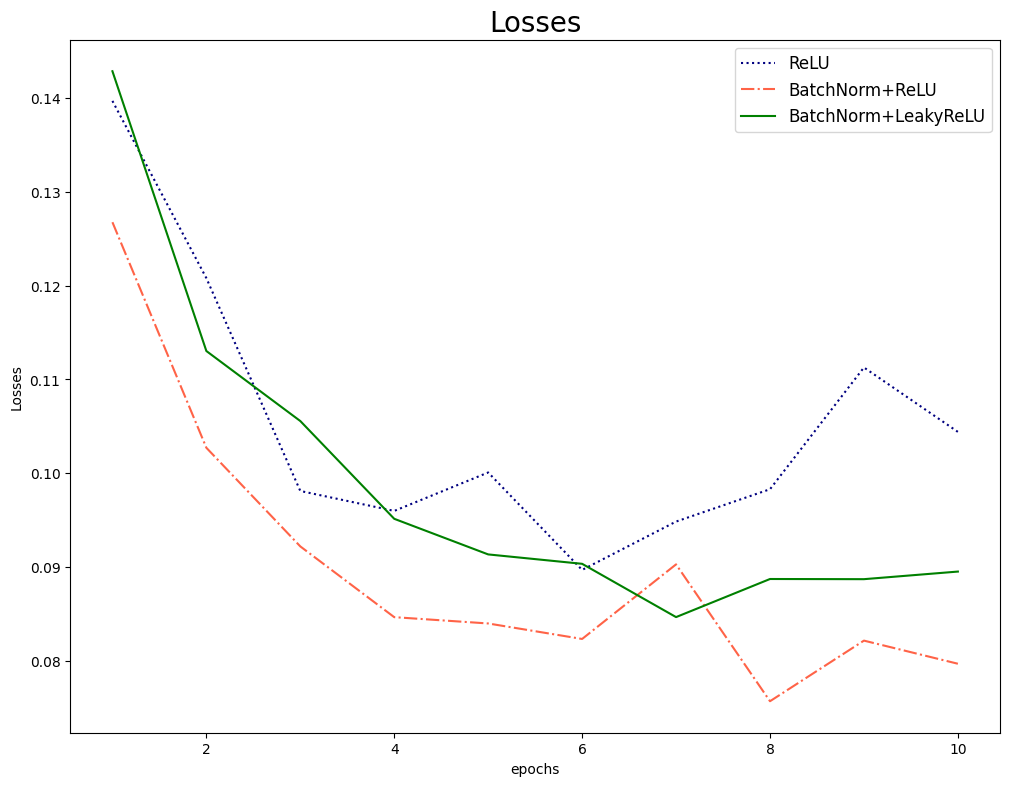

In [12]:
# 시각화하여 epoch 별 검증 손실 감소 추이 확인
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,9))
plt.plot(np.arange(1,11), history_a.history['val_loss'], color='navy',linestyle=':')
plt.plot(np.arange(1,11), history_b.history['val_loss'], color='tomato',linestyle='-.')
plt.plot(np.arange(1,11), history_c.history['val_loss'], color='green',linestyle='-')

plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.legend(['ReLU','BatchNorm+ReLU','BatchNorm+LeakyReLU'],fontsize=12)
plt.show()

-> 데이터 크기가 더 크면 더 뚜렷한 차이 발생

# 06 모델 저장 및 불러오기

**6-1 모델을 파일로 저장**
* save() 메소드를 이용해 가중치가 업데이트된 모델 인스턴스 저장
* HDFF5는 .h5 확장자를 포함하는 경우 (대용량)

In [13]:
# 모델을 h5 포맷으로 저장
model_c.save('h5-model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**6-2 저장된 모델 복원**

In [14]:
# 모델 복원
h5_model = tf.keras.models.load_model('h5-model.h5')
h5_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                     

* 복원한 모델을 검증해 복원이 잘 되었는지 확인

In [15]:
# 모델 검증
loss, acc = h5_model.evaluate(x_test,y_test,verbose=0)
print(f'h5 model loss: {loss:.5f}, acc:{acc:.5f}')

h5 model loss: 0.08953, acc:0.97540


* h5 확장자 생략 시, savedmodel 포맷으로 저장됨 (기본으로 지원하는 파일 포맷)

In [16]:
# 모델을 SavedModel 포맷으로 저장
model_c.save('saved-model')

In [17]:
# 모델 복원
saved_model = tf.keras.models.load_model('saved-model')
saved_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                     

In [18]:
# 모델 검증
loss, acc = saved_model.evaluate(x_test,y_test,verbose=0)
print(f'saved model loss: {loss:.5f}, acc:{acc:.5f}')

saved model loss: 0.08953, acc:0.97540


# 07 복잡한 모델 생성

**7-1 함수형 API**
* 함수형으로 모델을 생성한다면 다중 입력, 다중 출력, 입출력 공유 등의 기능이 가능 (sequence는 단방향 모델만 가능)


In [19]:
# 모델의 레이어를 체인 구조로 연결 INPUT 레이어 정의
input_layer = tf.keras.Input(shape=(28,28), name='InputLayer')

# 모델의 레이어를 체인 구조로 연결
x1 = tf.keras.layers.Flatten(name='Flatten')(input_layer)
x2 = tf.keras.layers.Dense(256, activation='relu',name='Dense1')(x1)
x3 = tf.keras.layers.Dense(64, activation='relu',name='Dense2')(x2)
x4 = tf.keras.layers.Dense(10, activation='softmax',name='OutputLayer')(x3)

-> name 매개변수로 레이어마다 이름 부여

In [20]:
# 모델 생성
func_model = tf.keras.Model(inputs=input_layer, outputs=x4, name='FunctionalModel')

# 모델 요약
func_model.summary()

Model: "FunctionalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28)]          0         
                                                                 
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 Dense1 (Dense)              (None, 256)               200960    
                                                                 
 Dense2 (Dense)              (None, 64)                16448     
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


-> 입력층과 출력층을 지정해주어 모델 생성 (name에 지정한 이름이 summary에 출력
* plot_model 모듈로 모델의 구조도 시각

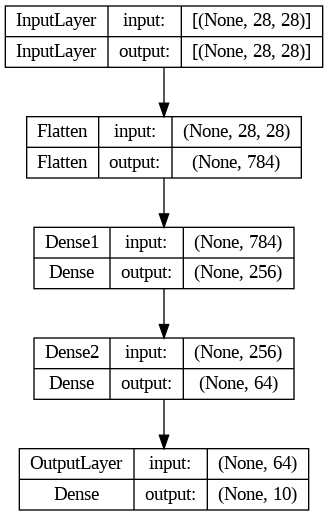

In [21]:
from tensorflow.keras.utils import plot_model

# 구조도 시각화
plot_model(func_model, show_shapes=True, show_layer_names=True, to_file='model.png')

-> show_shapes = True : 입출력 shape 출력, show_layer_names = True : 레이어 이름 출력
* 함수형 api도 sequential api와 유사하게 compile, fit, evaluate 과정

In [22]:
# 컴파일
func_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
func_model.fit(x_train, y_train, epochs=3)

# 검증
loss,acc = func_model.evaluate(x_test,y_test, verbose=0)
print(f'Functional Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2162 - accuracy: 0.9366
Epoch 2/3
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0877 - accuracy: 0.9725
Epoch 3/3
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0596 - accuracy: 0.9811
Functional Model] loss: 0.08215, acc: 0.97440


**7-2 모델 서브클래싱**
* model 클래스를 직접 상속받아 사용자가 직접 서브클래스로 딥러닝 모델 생성

In [24]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel,self).__init__()
    # 초기값 설정
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(256, activation='relu')
    self.dense2 = tf.keras.layers.Dense(64, activation='relu')
    self.dense3 = tf.keras.layers.Dense(10, activation='softmax')

  # method overiding
  # 훈련용 함수 정의
  # x는 input
  def call(self,x):
    x = self.flatten(x)
    x= self.dense1(x)
    x= self.dense2(x)
    x= self.dense3(x)
    return x

In [26]:
# 모델 생성
mymodel = MyModel()

# 모델의 이름 설정
mymodel._name = 'subclass_model'

# 모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28,28)))

# 모델 요약
mymodel.summary()

Model: "subclass_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_18 (Dense)            multiple                  200960    
                                                                 
 dense_19 (Dense)            multiple                  16448     
                                                                 
 dense_20 (Dense)            multiple                  650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# 컴파일
mymodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# 훈련
mymodel.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2105 - accuracy: 0.9370
Epoch 2/3
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0872 - accuracy: 0.9734
Epoch 3/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0594 - accuracy: 0.9816
Subclassing Model] loss: 0.08220, acc: 0.97340


**7-3 서브클래싱 모델 파라미터를 활용한 생성**
* 모델의 생성자 파라미터를 추가하여 동적으로 레이어의 유닛 개수 초기화

In [28]:
class MyModel(tf.keras.Model):

  # 생성자 파라미터 추가
  def __init__(self, units, num_classes):
    super(MyModel, self).__init__()
    # 초기값 설정
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(units, activation='relu')
    self.dense2 = tf.keras.layers.Dense(units/4, activation='relu')
    self.dense3 = tf.keras.layers.Dense(num_classes, activation='softmax')

  # method overiding
  # 훈련용 함수 정의
  # x는 input
  def call(self,x):
    x = self.flatten(x)
    x= self.dense1(x)
    x= self.dense2(x)
    x= self.dense3(x)
    return x

In [29]:
# 모델 생성
mymodel = MyModel(256,10)

# 모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28,28)))

# 모델 요약
mymodel.summary()

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 dense_21 (Dense)            multiple                  200960    
                                                                 
 dense_22 (Dense)            multiple                  16448     
                                                                 
 dense_23 (Dense)            multiple                  650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
# 컴파일
mymodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# 훈련
mymodel.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2189 - accuracy: 0.9360
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0892 - accuracy: 0.9722
Epoch 3/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0591 - accuracy: 0.9811
Subclassing Model] loss: 0.07660, acc: 0.97600
